# S&P 500 Time Series Anomaly Detection Using LSTM
This ML script uses a Tensorflow/Keras implementation of the LSTM (Long short-term memory) algorithm for time series analysis. It detects anomalies (as determined by mean absolute error (MAE)) relative to other months in the S&P 500's closing price history. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pandas.plotting import register_matplotlib_converters
from pylab import rcParams
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

seed = 100
np.random.seed(100)
tf.random.set_seed(100)

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', font_scale=1.25)
rcParams['figure.figsize'] = 16, 9


## Data Preprocessing & EDA

In [2]:
df = pd.read_csv('./data/spx.csv', parse_dates=['date'], index_col='date')
df.head()


,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


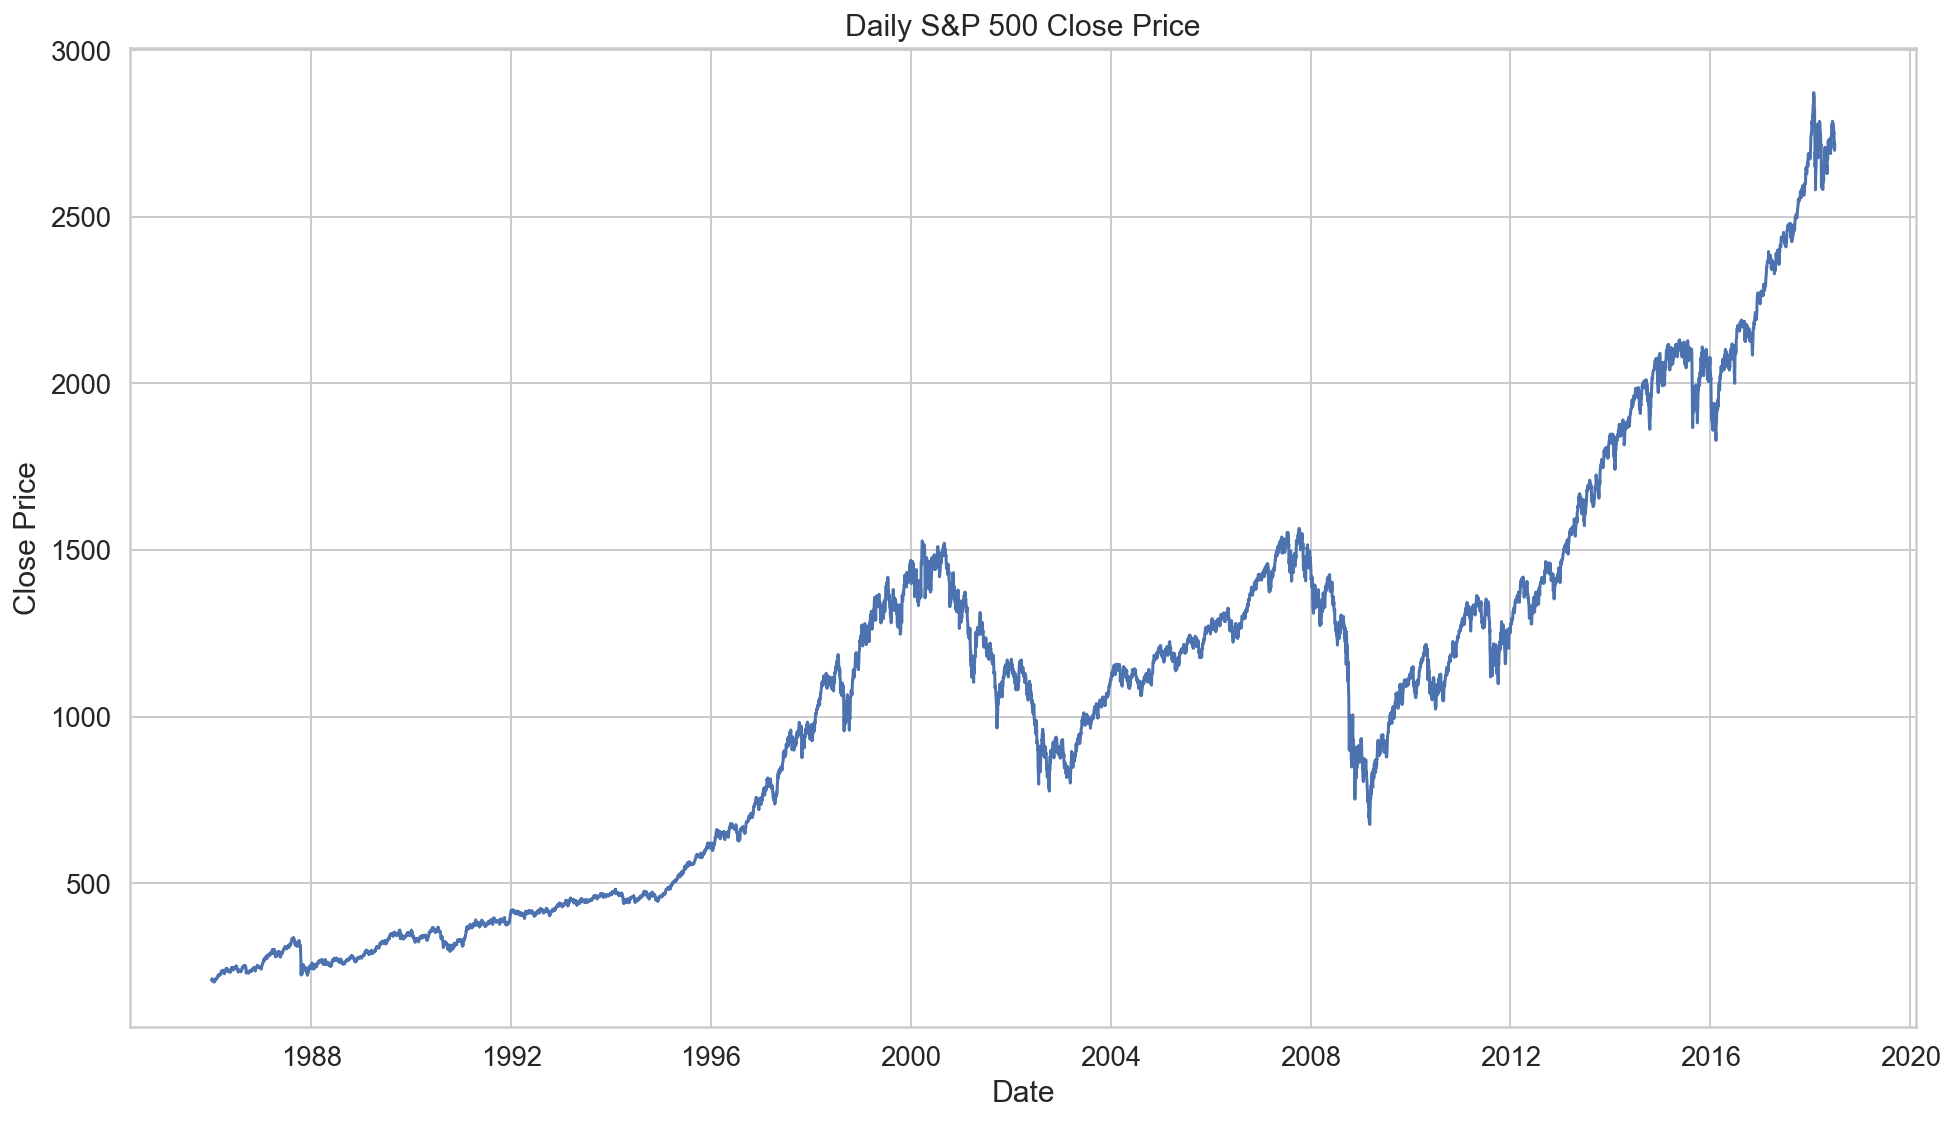

In [3]:
plt.plot(df, label='close price')
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Daily S&P 500 Close Price");


In [4]:
train_size = int(len(df) * .95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
train.shape, test.shape


((7782, 1), (410, 1))

In [5]:
scaler = StandardScaler()
scaler = scaler.fit(train[['close']])
train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])


In [6]:
def format_time_series_data(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


In [7]:
steps = 30
X_train, y_train = format_time_series_data(train[['close']], train.close, steps)
X_test, y_test = format_time_series_data(test[['close']], test.close, steps)
X_train.shape


(7752, 30, 1)

## LSTM Anomaly Detection: MAE Loss Function, Adam Optimizer

In [8]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(rate=.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))

model.add(keras.layers.LSTM(units=128, return_sequences=True))
model.add(keras.layers.Dropout(rate=.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')


In [9]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=16,
    validation_split=.05,
    shuffle=False
)


Train on 7364 samples, validate on 388 samples
Epoch 1/20
7364/7364 [==============================] - 10s 1ms/sample - loss: 0.1193 - val_loss: 0.1023
Epoch 2/20
7364/7364 [==============================] - 7s 987us/sample - loss: 0.0720 - val_loss: 0.0682
Epoch 3/20
7364/7364 [==============================] - 8s 1ms/sample - loss: 0.0693 - val_loss: 0.0666
Epoch 4/20
7364/7364 [==============================] - 7s 1ms/sample - loss: 0.0706 - val_loss: 0.0712
Epoch 5/20
7364/7364 [==============================] - 8s 1ms/sample - loss: 0.0685 - val_loss: 0.0838
Epoch 6/20
7364/7364 [==============================] - 8s 1ms/sample - loss: 0.0717 - val_loss: 0.0646
Epoch 7/20
7364/7364 [==============================] - 8s 1ms/sample - loss: 0.0691 - val_loss: 0.0888
Epoch 8/20
7364/7364 [==============================] - 8s 1ms/sample - loss: 0.0682 - val_loss: 0.0523
Epoch 9/20
7364/7364 [==============================] - 7s 1ms/sample - loss: 0.0684 - val_loss: 0.0757
Epoch 10/20
73

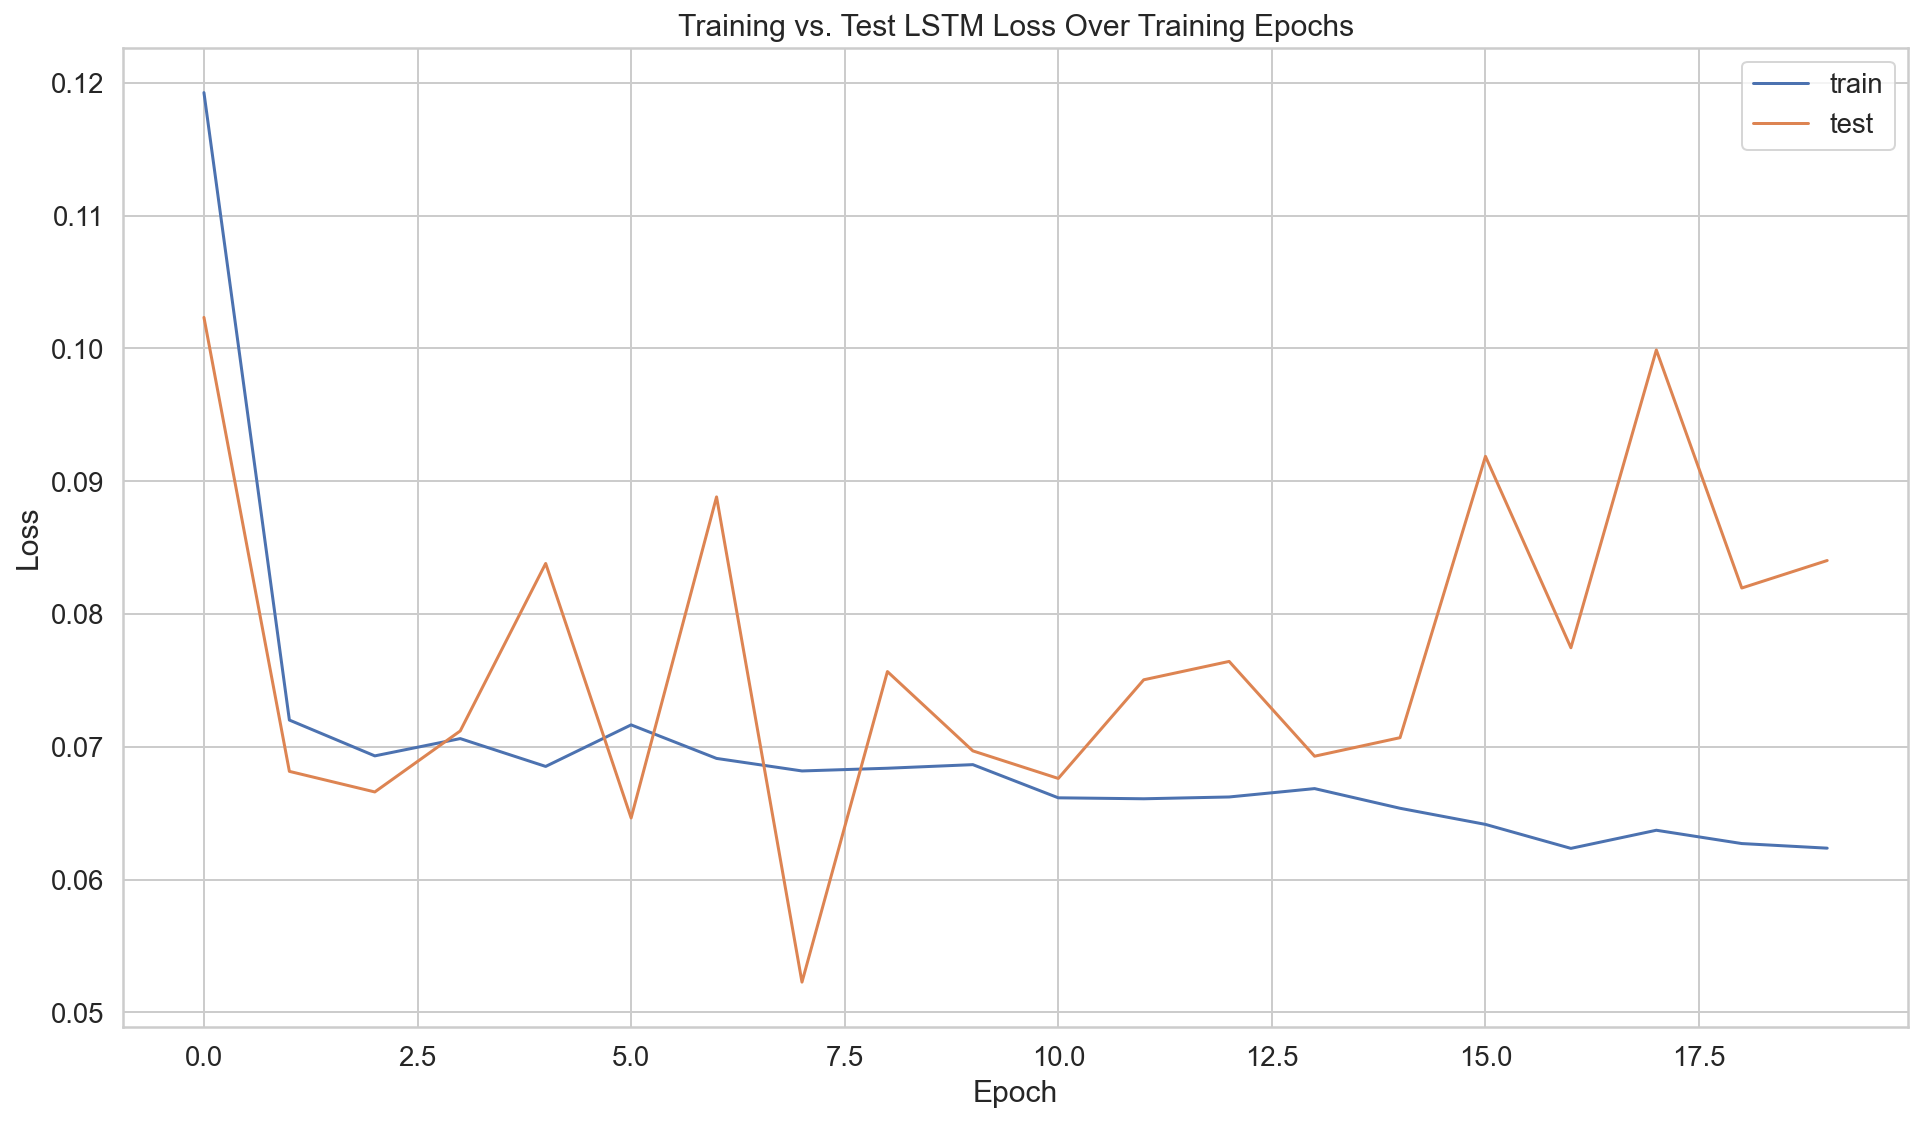

In [10]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Test LSTM Loss Over Training Epochs") 
plt.legend();


In [11]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)


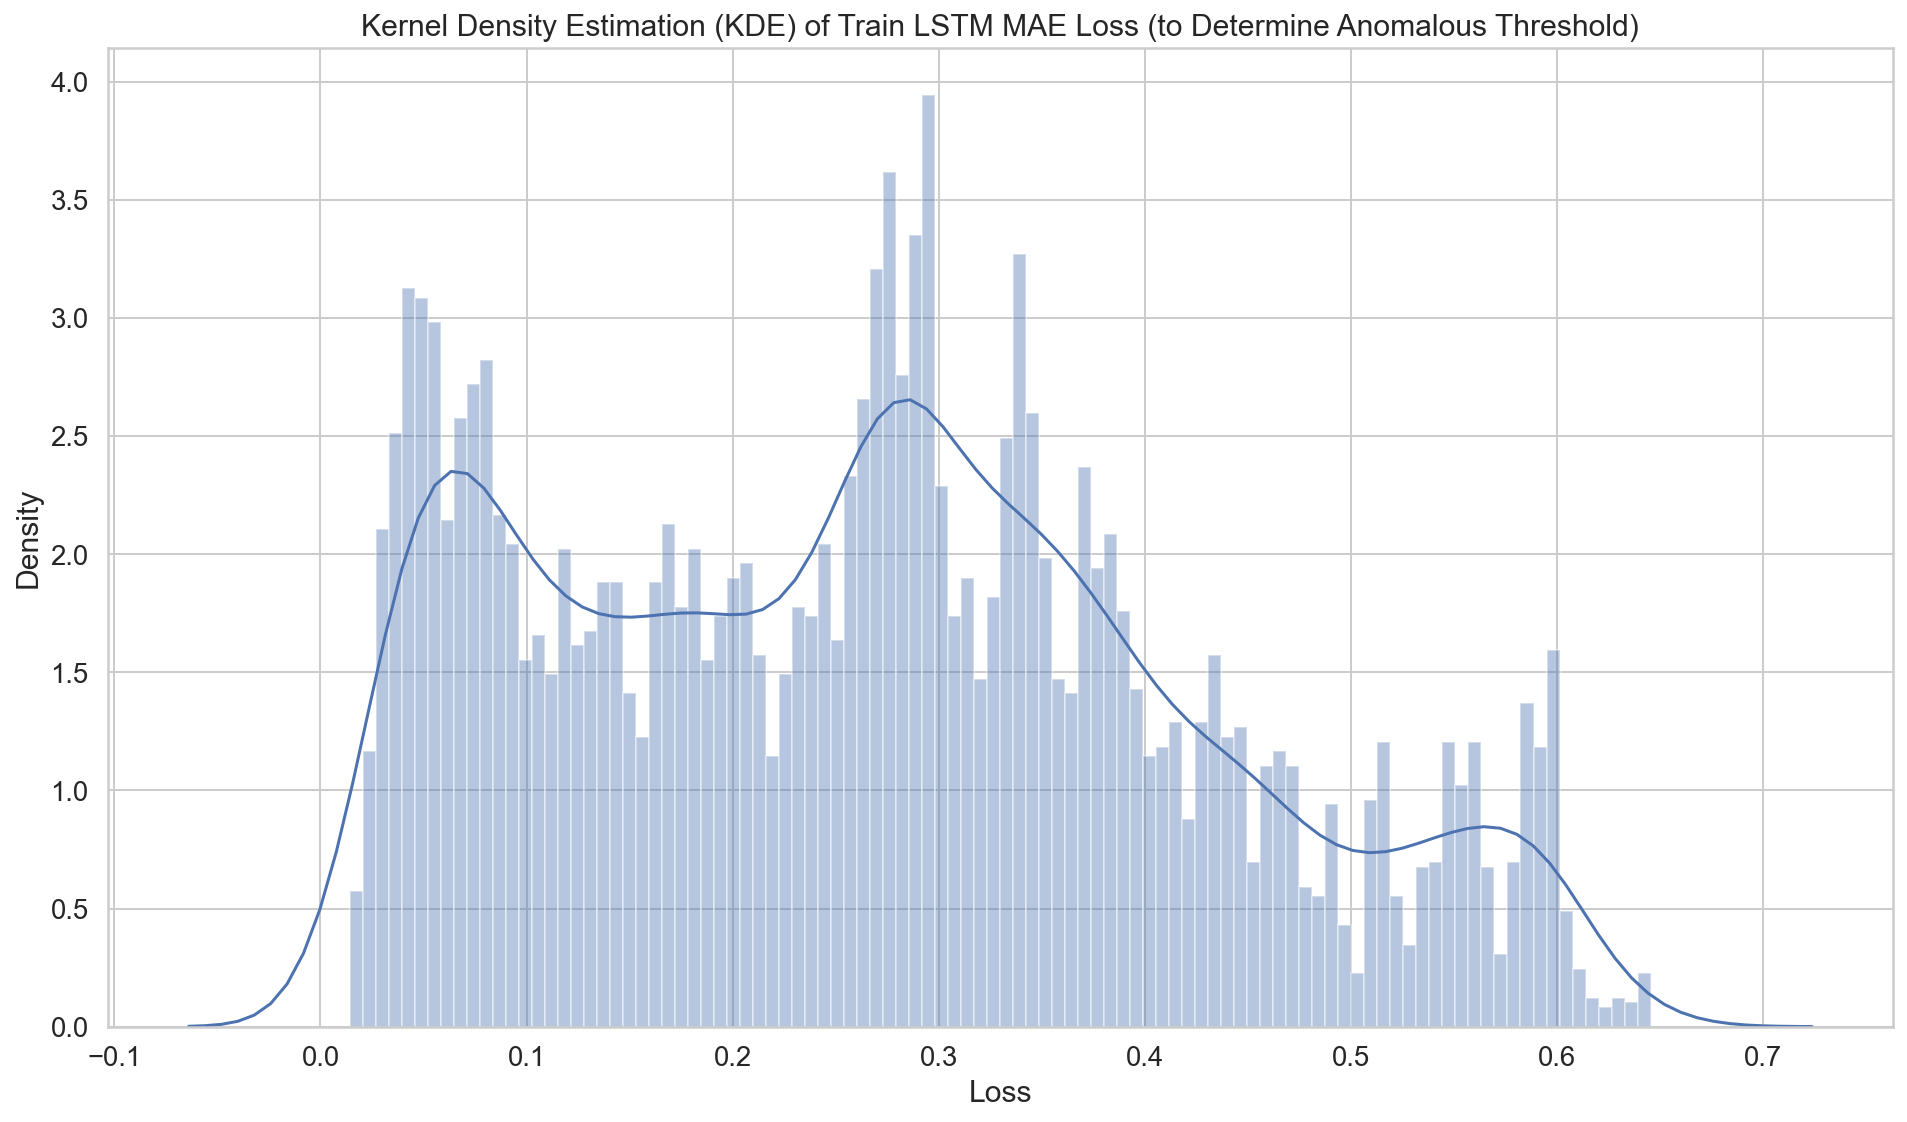

In [12]:
sns.distplot(train_mae_loss, bins=100, kde=True)
plt.ylabel("Density")
plt.xlabel("Loss")
plt.title("Kernel Density Estimation (KDE) of Train LSTM MAE Loss (to Determine Anomalous Threshold)");


In [13]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)


In [14]:
anomaly_thresold = 0.73
test_score_df = pd.DataFrame(index=test[steps:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = anomaly_thresold
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[steps:].close


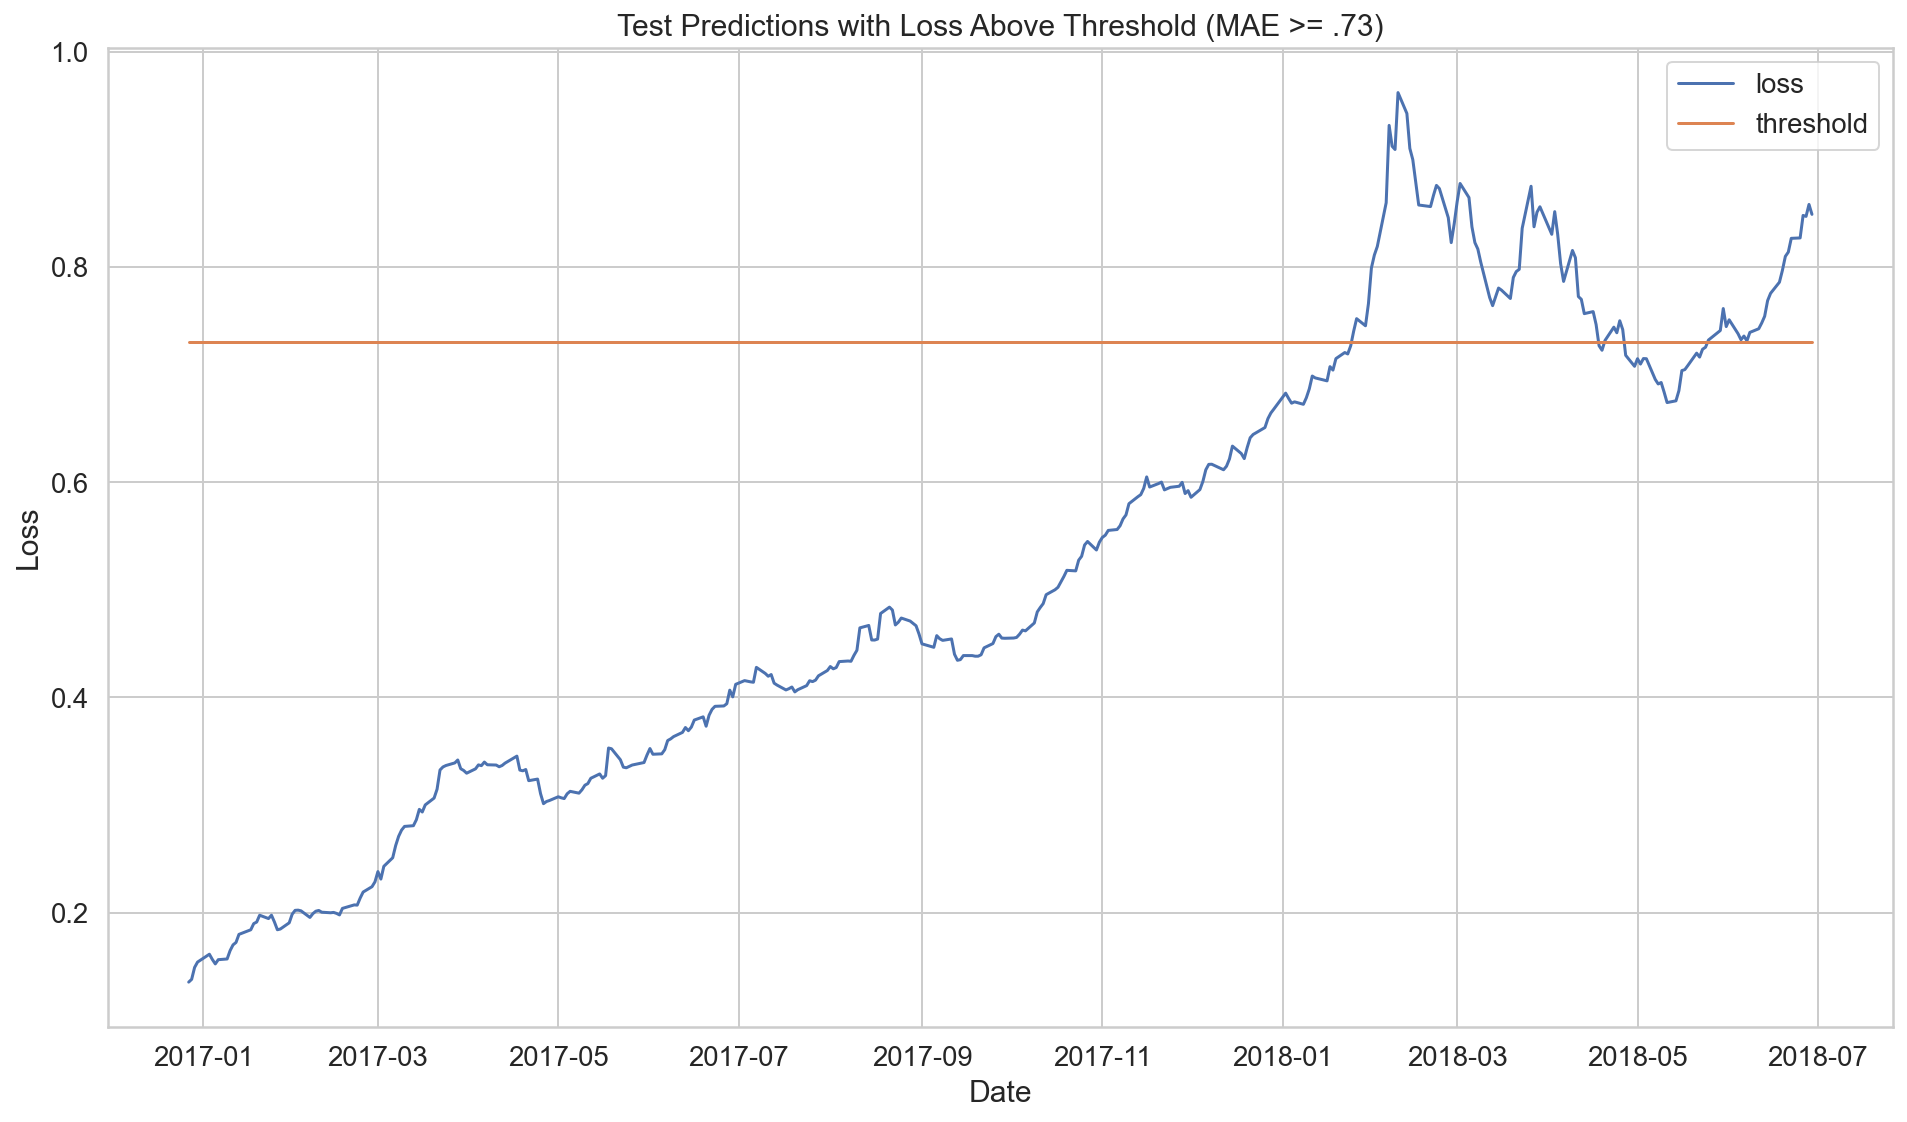

In [15]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xlabel("Date")
plt.ylabel("Loss")
plt.title("Test Predictions with Loss Above Threshold (MAE >= .73)") 
plt.legend();


In [16]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()


,loss,threshold,anomaly,close
date,,,,
2018-01-25,0.740335,0.73,True,3.464136
2018-01-26,0.752013,0.73,True,3.527284
2018-01-29,0.745397,0.73,True,3.490958
2018-01-30,0.766018,0.73,True,3.432543
2018-01-31,0.799098,0.73,True,3.435135


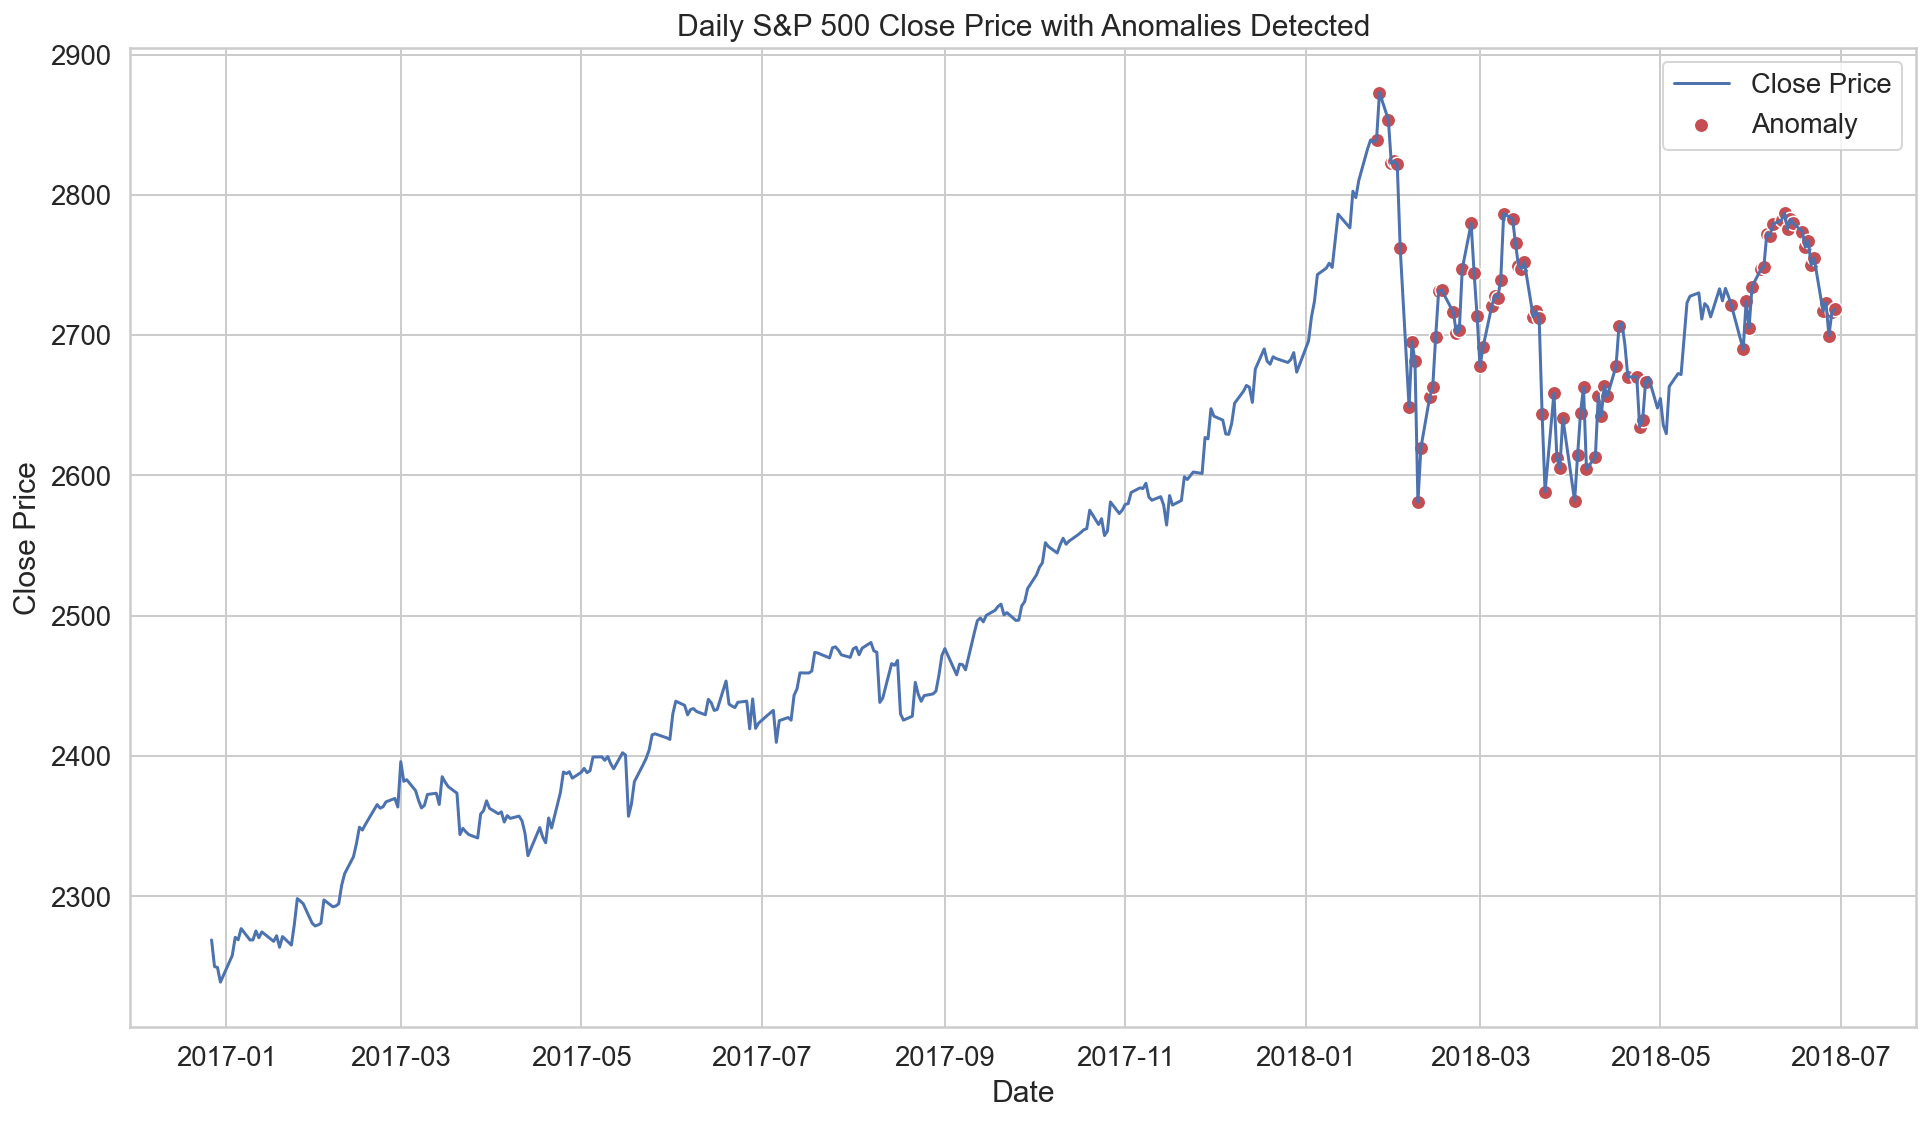

In [17]:
plt.plot(
  test[steps:].index,
  scaler.inverse_transform(test[steps:].close),
  label='Close Price'
)

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close),
  color=sns.color_palette()[3],
  s=52,
  label='Anomaly'
)

plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Daily S&P 500 Close Price with Anomalies Detected") 
plt.legend();
